Libraries

In [5]:
# basic
import pandas as pd
import numpy as np
import pickle as pk
import os, joblib
from copy import deepcopy

from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GroupKFold, KFold, GroupShuffleSplit

# pytorch
import torch
import torch.nn as nn
from torch import optim
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import StepLR

# XenonPy
from xenonpy.datatools import Splitter
from xenonpy.datatools.transform import Scaler
from xenonpy.utils import ParameterGenerator
from xenonpy.model import SequentialLinear
from xenonpy.model.utils import regression_metrics, classification_metrics
from xenonpy.model.training.dataset import ArrayDataset
from xenonpy.model.training import Trainer, Checker, Adam, MSELoss
from xenonpy.model.training.extension import TensorConverter, Validator, Persist

# plotting figures
import matplotlib.pyplot as plt
import seaborn as sns

# user-friendly printout
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import xenonpy
xenonpy.__version__


'0.6.5'

User parameters (recorded the actual values when training the model for the paper)

In [19]:
cuda_opt = 'cuda:0' # change to cpu if not using GPU
cvtestidx = 1 # index of the set of randomly split test data stored in test_cv_idx.pkl

# data splitting
test_ratio = 0.2 # ratio of total data in computational Chi data and solubility data used for test data
n_CV_val = 5 # k-fold cross-validation for hyperparameter tuning
test_ratio_final = 0.2 # ratio of training data used for validation during final training after selection of the best hyperparameters

# hyperparameters
n_hpara = 100 # number of samples in the hyperparameter space
learning_rates = [0.001, 0.01] # range for learning rates
alpha1s = [0.0, 1.0] # range for lambda_c
alpha2s = [0.0, 1.0] # range for lambda_s
dim_outs = [3, 40] # range for dimension of Z

# model training
dir_base = f'hyper_groupCV/MT_testset_{cvtestidx}' # output directory for hyperparameter selection
n_final_model = 10 # number of retrained model ensembles after selection of the best hyperparameters

n_NNlayer = 3 # number of layer in the sub-network of fully connection MLPs
sch_step_size = 10 # step size for learning rate scheduler
sch_gamma = 0.5 # gamma parameter for learning rate scheduler
epochs_s = 0 # number of pre-training steps based on solubility data (not used in the paper)
epochs = 50 # number of max. epoch for the main training
burn_in = 1 # burn in epoch (skip this number of epoch when selecting the epoch with the lowest validation loss)

n_minibatch_PI = 20 # number of minibatch for solubility data
n_minibatch_COSMO = 10 # number of minibatch for computational Chi data
n_minibatch_CHI = 5 # number minibatch for experimental Chi data
n_factor_CHI = int(n_minibatch_PI/n_minibatch_CHI)
n_factor_COSMO = int(n_minibatch_PI/n_minibatch_COSMO)

# other internal parameters
temp_dim = 1 # take 1 or 2 only. 1: linear temperature dependence only; 2: 1/T^2 term included
loss_factor_target = 1 # multiplier to adjust target loss contribution to total loss for model training
no_target_BN = True # True: do not include experimental Chi data for batch normalization in training
no_COSMO_BN = True # True: do not include COSMO data for batch normalization in training
seed_hyper = 2022 # random seed for hyperparameter samples


### Load data

In [7]:
dir_load = 'sample_data'

data_PI = pd.read_csv(f'{dir_load}/data_PI.csv', index_col=0)
data_COSMO = pd.read_csv(f'{dir_load}/data_COSMO.csv', index_col=0)
data_Chi = pd.read_csv(f'{dir_load}/data_Chi.csv', index_col=0)
desc_PI = pd.read_csv(f'{dir_load}/desc_PI.csv', index_col=0)
desc_COSMO = pd.read_csv(f'{dir_load}/desc_COSMO.csv', index_col=0)
desc_Chi = pd.read_csv(f'{dir_load}/desc_Chi.csv', index_col=0)

with open(f'{dir_load}/desc_names.pkl', 'rb') as f:
    tmp = pk.load(f)
dname_p_ff = deepcopy(tmp['p_ff'])
dname_p_rd = deepcopy(tmp['p_rd'])
dname_s_ff = deepcopy(tmp['s_ff'])
dname_s_rd = deepcopy(tmp['s_rd'])

with open(f'{dir_load}/test_cv_idx.pkl', 'rb') as f:
    tmp = pk.load(f)
tmp_idx_trs = deepcopy(tmp['train'])
tmp_idx_vals = deepcopy(tmp['test'])


### Split data

In [8]:
# Exp-Chi data splitting
idx = cvtestidx
idx_split_t = {'idx_tr': deepcopy(tmp_idx_trs[idx]), 'idx_te': deepcopy(tmp_idx_vals[idx])}
idx_split_t['idx_tr'].shape[0], idx_split_t['idx_te'].shape[0]

# COSMO data splitting (exclude test ps_pair cases first)
idx = data_COSMO['ps_pair'].apply(lambda x: x in data_Chi['ps_pair'].loc[idx_split_t['idx_te']].values)
idx.sum()

sp_s = Splitter(size=(~idx).sum(), test_size=test_ratio, random_state=0)
_, tmp_idx = sp_s.split(idx.index[~idx].values)
idx.loc[tmp_idx] = True
idx_split_s = {'idx_tr': data_COSMO.index[~idx], 'idx_te': data_COSMO.index[idx]}
idx.sum(), (~idx).sum(), idx.sum()/idx.shape[0]*100

# PI data splitting (exclude test polymer cases first)
idx = data_PI['ps_pair'].apply(lambda x: x in data_Chi['ps_pair'].loc[idx_split_t['idx_te']].values)
idx.sum()

sp_s0 = Splitter(size=(~idx).sum(), test_size=test_ratio, random_state=0)
_, tmp_idx = sp_s0.split(idx.index[~idx].values)
idx.loc[tmp_idx] = True
idx_split_s0 = {'idx_tr': data_PI.index[~idx], 'idx_te': data_PI.index[idx]}
idx.sum(), (~idx).sum(), idx.sum()/idx.shape[0]*100


(952, 238)

241

(434, 772, 35.98673300165838)

238

(429, 761, 36.05042016806723)

### Process data for training

Scale descriptors

In [9]:
dname_rd = np.concatenate([dname_p_rd, dname_s_rd])
desc_s0_s = deepcopy(desc_PI)
desc_s_s = deepcopy(desc_COSMO)
desc_t_s = deepcopy(desc_Chi)

tmp_desc = pd.concat([desc_s0_s.loc[idx_split_s0['idx_tr'],dname_rd], desc_s_s.loc[idx_split_s['idx_tr'],dname_rd], desc_t_s.loc[idx_split_t['idx_tr'],dname_rd]], axis=0)
# tmp_desc = desc_t_s.loc[idx_split_t['idx_tr'],dname_rd]

x_scaler = Scaler().yeo_johnson().standard()
_ = x_scaler.fit(tmp_desc.drop_duplicates(keep='first'))
desc_s0_s[dname_rd] = x_scaler.transform(desc_s0_s[dname_rd])
desc_s_s[dname_rd] = x_scaler.transform(desc_s_s[dname_rd])
desc_t_s[dname_rd] = x_scaler.transform(desc_t_s[dname_rd])


/home/stewu/mambaforge/envs/xepy38/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:3253: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


Filter out constant descriptors (based on training data)

In [10]:
# filter out constant descriptors
dname_rd = np.concatenate([dname_p_rd, dname_s_rd])
tmp_desc = pd.concat([desc_s0_s.loc[idx_split_s0['idx_tr'],dname_rd], desc_s_s.loc[idx_split_s['idx_tr'],dname_rd], desc_t_s.loc[idx_split_t['idx_tr'],dname_rd]], axis=0)
dname_rd_fil = tmp_desc.columns[tmp_desc.std() != 0]
dname_p_rd_fil = np.intersect1d(dname_rd_fil, dname_p_rd)
dname_s_rd_fil = np.intersect1d(dname_rd_fil, dname_s_rd)

dname_ff = np.concatenate([dname_p_ff, dname_s_ff])
tmp_desc = pd.concat([desc_s0_s.loc[idx_split_s0['idx_tr'],dname_ff], desc_s_s.loc[idx_split_s['idx_tr'],dname_ff], desc_t_s.loc[idx_split_t['idx_tr'],dname_ff]], axis=0)
dname_ff_fil = tmp_desc.columns[tmp_desc.std() != 0]
dname_p_ff_fil = np.intersect1d(dname_ff_fil, dname_p_ff)
dname_s_ff_fil = np.intersect1d(dname_ff_fil, dname_s_ff)

dname_p = np.concatenate([dname_p_ff_fil, dname_p_rd_fil])
dname_s = np.concatenate([dname_s_ff_fil, dname_s_rd_fil])


Setup and scale y values and temperatures

In [20]:
y_s0 = data_PI[['soluble']]
y_s0.columns = ['y']
y_s = data_COSMO[['chi']]
y_s.columns = ['y']
y_t = data_Chi[['chi']]
y_t.columns = ['y']

if temp_dim == 1:
    temp_s = 1/(data_COSMO[['temp']] + 273.15)
    temp_s.columns = ['T1']
    temp_t = 1/(data_Chi[['temp']] + 273.15)
    temp_t.columns = ['T1']
elif temp_dim == 2:
    temp_s = pd.concat([1/(data_COSMO[['temp']] + 273.15), (data_COSMO[['temp']] + 273.15)**(-2)], axis=1)
    temp_s.columns = ['T1', 'T2']
    temp_t = pd.concat([1/(data_Chi[['temp']] + 273.15), (data_Chi[['temp']] + 273.15)**(-2)], axis=1)
    temp_t.columns = ['T1', 'T2']


In [23]:
# ys_scaler = Scaler().min_max((-1,1))
ys_scaler = Scaler().standard()
_ = ys_scaler.fit(y_s.loc[idx_split_s['idx_tr']].reset_index(drop=True))
y_s_s = ys_scaler.transform(y_s)

# yt_scaler = Scaler().min_max((-1,1))
yt_scaler = Scaler().standard()
_ = yt_scaler.fit(y_t.loc[idx_split_t['idx_tr']].reset_index(drop=True))
y_t_s = yt_scaler.transform(y_t)


In [24]:
# temp_scaler = Scaler().min_max((-1,1))
tempS_scaler = Scaler().standard()
_ = tempS_scaler.fit(temp_s.loc[idx_split_s['idx_tr'],:])
temp_s_s = tempS_scaler.transform(temp_s)

tempT_scaler = Scaler().standard()
_ = tempT_scaler.fit(temp_t.loc[idx_split_t['idx_tr'],:])
temp_t_s = tempT_scaler.transform(temp_t)


### Build model

In [26]:
# fixed linearly reducing pyramid shape
def neuron_vector(nL, in_neu, out_neu):
    return [int(x) for x in np.rint(np.linspace(in_neu, out_neu, nL+2))[1:-1]]

# module of the final NN
if temp_dim == 1:
    class Chi_Model(nn.Module):
        def __init__(self, sp_mdl_p, sp_mdl_s, dim_ur):
            super(Chi_Model, self).__init__()

            self.network1 = deepcopy(sp_mdl_p)
            self.network2 = deepcopy(sp_mdl_s)

            self.out_lin = nn.Linear(dim_ur, 5)
            self.out_act = nn.Sigmoid()
            self.dim_ur = dim_ur

        def forward(self, x1, x2, temp):
            ur1 = self.network1(x1)
            ur2 = self.network2(x2)

            sp = (ur1[:,:self.dim_ur] - ur2[:,:self.dim_ur])**2
            r1 = ur1[:,self.dim_ur:]**2
            r2 = ur2[:,self.dim_ur:]**2

            z0 = sp - r1 - r2
            z = self.out_lin(z0)

            z_soluble = self.out_act(z[:,0:1])

            As = z[:,1:2]
            Bs = z[:,2:3]
            z_comp = As + Bs*temp[:,0:1]

            At = z[:,3:4]
            Bt = z[:,4:5]
            z_target = At + Bt*temp[:,0:1]

            y = torch.cat((z_soluble, z_comp, z_target, z, z0), dim=1)

            return y
        
elif temp_dim == 2:
    class Chi_Model(nn.Module):
        def __init__(self, sp_mdl_p, sp_mdl_s, dim_ur):
            super(Chi_Model, self).__init__()

            self.network1 = deepcopy(sp_mdl_p)
            self.network2 = deepcopy(sp_mdl_s)

            self.out_lin = nn.Linear(dim_ur, 7)
            self.out_act = nn.Sigmoid()
            self.dim_ur = dim_ur

        def forward(self, x1, x2, temp):
            ur1 = self.network1(x1)
            ur2 = self.network2(x2)

            sp = (ur1[:,:self.dim_ur] - ur2[:,:self.dim_ur])**2
            r1 = ur1[:,self.dim_ur:]**2
            r2 = ur2[:,self.dim_ur:]**2

            z0 = sp - r1 - r2
            z = self.out_lin(z0)

            z_soluble = self.out_act(z[:,0:1])

            As = z[:,1:2]
            Bs = z[:,2:3]
            Cs = z[:,3:4]
            z_comp = As + Bs*temp[:,0:1] + Cs*temp[:,1:2]

            At = z[:,4:5]
            Bt = z[:,5:6]
            Ct = z[:,6:7]
            z_target = At + Bt*temp[:,0:1] + Ct*temp[:,1:2]

            y = torch.cat((z_soluble, z_comp, z_target, z, z0), dim=1)

            return y
    

In [27]:
# functions to save and load the NN model
def save_NN(paras_p, paras_s, dim_out, c_mdl, file_name):
    torch.save({'model_p': paras_p, 'model_s': paras_s, 'chi': c_mdl.state_dict(), 'dim_out': dim_out}, file_name)
    
def load_NN(file_name):
    tmp_paras = torch.load(file_name)
    c_model = Chi_Model(SequentialLinear(**tmp_paras['model_p']), SequentialLinear(**tmp_paras['model_s']), tmp_paras['dim_out'])
    _ = c_model.load_state_dict(tmp_paras['chi'])
    return c_model


### Hyperparameter tuning with grid search and CV

Group validation

In [28]:
poly_group = data_Chi.loc[idx_split_t['idx_tr'],'ps_pair']

gp_cv = GroupKFold(n_splits=n_CV_val)
idx_trs, idx_vals = [], []

np.random.seed(0)
for idx_tr, idx_val in gp_cv.split(y_t['y'].loc[idx_split_t['idx_tr']], groups=poly_group.to_list()):
    idx_trs.append(y_t['y'].loc[idx_split_t['idx_tr']].iloc[idx_tr].index.values)
    idx_vals.append(y_t['y'].loc[idx_split_t['idx_tr']].iloc[idx_val].index.values)


Prepare for training

In [29]:
criterion_source0 = nn.BCELoss()
criterion_source = nn.MSELoss()
criterion_target = nn.MSELoss()

dim_in_p = len(dname_p)
dim_in_s = len(dname_s)

np.random.seed(seed_hyper)
hyper_para = pd.DataFrame({'alpha1': np.random.uniform(alpha1s[0], alpha1s[1], n_hpara), 
                           'alpha2': np.random.uniform(alpha2s[0], alpha2s[1], n_hpara),
                           'dim_out': np.random.randint(dim_outs[0], dim_outs[1], n_hpara),
                           'lr': np.random.uniform(learning_rates[0], learning_rates[1], n_hpara)})

os.makedirs(dir_base, exist_ok=True)
hyper_para.to_csv(f'{dir_base}/list_hyperparameters.csv')

XS0_P_TE = torch.tensor(desc_s0_s.loc[idx_split_s0['idx_te'], dname_p].values.astype("float"), dtype=torch.float32, device=cuda_opt)
XS0_S_TE = torch.tensor(desc_s0_s.loc[idx_split_s0['idx_te'], dname_s].values.astype("float"), dtype=torch.float32, device=cuda_opt)
XS0_T_TE = torch.zeros(idx_split_s0['idx_te'].shape[0], temp_dim, device=cuda_opt)
YS0_TE = torch.tensor(y_s0.loc[idx_split_s0['idx_te'], :].values.astype("float"), dtype=torch.float32, device=cuda_opt)

XS_P_TE = torch.tensor(desc_s_s.loc[idx_split_s['idx_te'], dname_p].values.astype("float"), dtype=torch.float32, device=cuda_opt)
XS_S_TE = torch.tensor(desc_s_s.loc[idx_split_s['idx_te'], dname_s].values.astype("float"), dtype=torch.float32, device=cuda_opt)
XS_T_TE = torch.tensor(temp_s_s.loc[idx_split_s['idx_te'], :].values.astype("float"), dtype=torch.float32, device=cuda_opt)
YS_TE = torch.tensor(y_s_s.loc[idx_split_s['idx_te'], :].values.astype("float"), dtype=torch.float32, device=cuda_opt)

XT_P_TE = torch.tensor(desc_t_s.loc[idx_split_t['idx_te'], dname_p].values.astype("float"), dtype=torch.float32, device=cuda_opt)
XT_S_TE = torch.tensor(desc_t_s.loc[idx_split_t['idx_te'], dname_s].values.astype("float"), dtype=torch.float32, device=cuda_opt)
XT_T_TE = torch.tensor(temp_t_s.loc[idx_split_t['idx_te'], :].values.astype("float"), dtype=torch.float32, device=cuda_opt)
YT_TE = torch.tensor(y_t_s.loc[idx_split_t['idx_te'], :].values.astype("float"), dtype=torch.float32, device=cuda_opt)

XS0_P_TR = torch.tensor(desc_s0_s.loc[idx_split_s0['idx_tr'], dname_p].values.astype("float"), dtype=torch.float32, device=cuda_opt)
XS0_S_TR = torch.tensor(desc_s0_s.loc[idx_split_s0['idx_tr'], dname_s].values.astype("float"), dtype=torch.float32, device=cuda_opt)
XS0_T_TR = torch.zeros(idx_split_s0['idx_tr'].shape[0], temp_dim, device=cuda_opt)
YS0_TR = torch.tensor(y_s0.loc[idx_split_s0['idx_tr'], :].values.astype("float"), dtype=torch.float32, device=cuda_opt)

XS_P_TR = torch.tensor(desc_s_s.loc[idx_split_s['idx_tr'], dname_p].values.astype("float"), dtype=torch.float32, device=cuda_opt)
XS_S_TR = torch.tensor(desc_s_s.loc[idx_split_s['idx_tr'], dname_s].values.astype("float"), dtype=torch.float32, device=cuda_opt)
XS_T_TR = torch.tensor(temp_s_s.loc[idx_split_s['idx_tr'], :].values.astype("float"), dtype=torch.float32, device=cuda_opt)
YS_TR = torch.tensor(y_s_s.loc[idx_split_s['idx_tr'], :].values.astype("float"), dtype=torch.float32, device=cuda_opt)


Training models

In [30]:
%%time

np.random.seed(0)

for iCV, (idx_tr, idx_val) in enumerate(zip(idx_trs, idx_vals)):
    XT_P_TR = torch.tensor(desc_t_s.loc[idx_tr, dname_p].values.astype("float"), dtype=torch.float32, device=cuda_opt)
    XT_S_TR = torch.tensor(desc_t_s.loc[idx_tr, dname_s].values.astype("float"), dtype=torch.float32, device=cuda_opt)
    XT_T_TR = torch.tensor(temp_t_s.loc[idx_tr, :].values.astype("float"), dtype=torch.float32, device=cuda_opt)
    YT_TR = torch.tensor(y_t_s.loc[idx_tr, :].values.astype("float"), dtype=torch.float32, device=cuda_opt)

    XT_P_VA = torch.tensor(desc_t_s.loc[idx_val, dname_p].values.astype("float"), dtype=torch.float32, device=cuda_opt)
    XT_S_VA = torch.tensor(desc_t_s.loc[idx_val, dname_s].values.astype("float"), dtype=torch.float32, device=cuda_opt)
    XT_T_VA = torch.tensor(temp_t_s.loc[idx_val, :].values.astype("float"), dtype=torch.float32, device=cuda_opt)
    YT_VA = torch.tensor(y_t_s.loc[idx_val, :].values.astype("float"), dtype=torch.float32, device=cuda_opt)

    for ii, h_paras in hyper_para.iterrows():
        alpha1 = h_paras['alpha1']
        alpha2 = h_paras['alpha2']
        dim_out = int(h_paras['dim_out'])
        learning_rate = h_paras['lr']

        generator_p = ParameterGenerator(
            in_features=dim_in_p,
            out_features=dim_out*2,
            h_neurons=dict(
                data=lambda x: neuron_vector(x, dim_in_p, dim_out*2), 
                repeat=[n_NNlayer]
            ),
            h_activation_funcs=(nn.Sigmoid(), ),
            h_dropouts=(0.0,)
        )

        generator_s = ParameterGenerator(
            in_features=dim_in_s,
            out_features=dim_out*2,
            h_neurons=dict(
                data=lambda x: neuron_vector(x, dim_in_s, dim_out*2), 
                repeat=[n_NNlayer]
            ),
            h_activation_funcs=(nn.Sigmoid(), ),
            h_dropouts=(0.0,)
        )
        
        for iM, ((paras_p, model_p), (paras_s, model_s)) in enumerate(zip(generator_p(num=1, factory=SequentialLinear), generator_s(num=1, factory=SequentialLinear))):
            dir_save = f'{dir_base}/cv{iCV}/hpara{ii}'
            os.makedirs(dir_save, exist_ok=True)

            c_model = Chi_Model(model_p, model_s, dim_out)
            c_model.to(cuda_opt)

            c_model.train()

            optimizer = optim.Adam(c_model.parameters(), lr=learning_rate, amsgrad=True)
            scheduler = StepLR(optimizer, step_size=sch_step_size, gamma=sch_gamma)

            learning_curve = pd.DataFrame()

            for t in range(epochs_s):
                # mini-batch of training data
                kf = KFold(n_splits=n_minibatch_PI, shuffle=True)
                idx_mb_s0 = [x for _, x in kf.split(XS0_P_TR)]

                # pre-training with PI
                for tt, ii_s0 in enumerate(idx_mb_s0):
                    c_model.train()

                    tmp_source0_train = c_model(XS0_P_TR[ii_s0,:], XS0_S_TR[ii_s0,:], XS0_T_TR[ii_s0,:])
                    py_source0_train = tmp_source0_train[:,0:1]
                    loss_source0_train = criterion_source0(py_source0_train, YS0_TR[ii_s0,:])

                    optimizer.zero_grad()
                    loss_source0_train.backward()
                    optimizer.step()

                    c_model.eval()
                    with torch.no_grad():
                        py_source_train = c_model(XS_P_TR, XS_S_TR, XS_T_TR)[:,1:2]
                        py_target_train = c_model(XT_P_TR, XT_S_TR, XT_T_TR)[:,2:3]
                        loss_source_train = criterion_source(py_source_train, YS_TR)
                        loss_target_train = criterion_target(py_target_train, YT_TR)*loss_factor_target
                        loss_train = alpha1*loss_source0_train + (1.0-alpha1)*(alpha2*loss_source_train + (1.0-alpha2)*loss_target_train)

                        py_target_val = c_model(XT_P_VA, XT_S_VA, XT_T_VA)[:,1:2]
                        loss_target_val = criterion_target(py_target_val, YT_VA)*loss_factor_target

                        py_source0_test = c_model(XS0_P_TE, XS0_S_TE, XS0_T_TE)[:,0:1]
                        py_source_test = c_model(XS_P_TE, XS_S_TE, XS_T_TE)[:,1:2]
                        py_target_test = c_model(XT_P_TE, XT_S_TE, XT_T_TE)[:,2:3]
                        loss_source0_test = criterion_source0(py_source0_test, YS0_TE)
                        loss_source_test = criterion_source(py_source_test, YS_TE)
                        loss_target_test = criterion_target(py_target_test, YT_TE)*loss_factor_target
                        loss_test = alpha1*loss_source0_test + (1.0-alpha1)*(alpha2*loss_source_test + (1.0-alpha2)*loss_target_test)

                    learning_curve = pd.concat([learning_curve, pd.Series({
                                            "Loss_Source0_Training": loss_source0_train.item(), 
                                            "Loss_Source0_Test": loss_source0_test.item(),
                                            "Loss_Source_Training": loss_source_train.item(), 
                                            "Loss_Source_Test": loss_source_test.item(),
                                            "Loss_Target_Training": loss_target_train.item(),
                                            "Loss_Target_Validation":loss_target_val.item(),
                                            "Loss_Target_Test":loss_target_test.item(),
                                            "Loss_Training":loss_train.item(),
                                            "Loss_Test":loss_test.item()},
                                           name=f'pre_{t}').to_frame().T], axis=0)

            # main training
            best_loss_val = np.inf
            for t in range(epochs):
                # mini-batch of training data
                kf = KFold(n_splits=n_minibatch_PI, shuffle=True)
                idx_mb_s0 = [x for _, x in kf.split(XS0_P_TR)]
                idx_mb_s, idx_mb_t = [], []
                for k in range(n_factor_COSMO):
                    kf = KFold(n_splits=n_minibatch_COSMO, shuffle=True)
                    idx_mb_s += [x for _, x in kf.split(XS_P_TR)]
                for k in range(n_factor_CHI):
                    kf = KFold(n_splits=n_minibatch_CHI, shuffle=True)
                    idx_mb_t += [x for _, x in kf.split(XT_P_TR)]

                for tt, (ii_s0, ii_s, ii_t) in enumerate(zip(idx_mb_s0, idx_mb_s, idx_mb_t)):
                    c_model.train()
                    if alpha1 > 0:
                        py_source0_train = c_model(XS0_P_TR[ii_s0,:], XS0_S_TR[ii_s0,:], XS0_T_TR[ii_s0,:])[:,0:1]
                        loss_source0_train = criterion_source0(py_source0_train, YS0_TR[ii_s0,:])
                    else:
                        loss_source0_train = torch.zeros(1, device=cuda_opt)

                    if (alpha2 > 0) and (alpha1 < 1):
                        if no_COSMO_BN:
                            c_model.eval()
                        else:
                            c_model.train()
                        py_source_train = c_model(XS_P_TR[ii_s,:], XS_S_TR[ii_s,:], XS_T_TR[ii_s,:])[:,1:2]
                        loss_source_train = criterion_source(py_source_train, YS_TR[ii_s,:])
                    else:
                        loss_source_train = torch.zeros(1, device=cuda_opt)

                    if (alpha1 < 1) and (alpha2 < 1):
                        if no_target_BN:
                            c_model.eval()
                        else:
                            c_model.train()
                        py_target_train = c_model(XT_P_TR[ii_t,:], XT_S_TR[ii_t,:], XT_T_TR[ii_t,:])[:,2:3]
                        loss_target_train = criterion_target(py_target_train, YT_TR[ii_t,:])*loss_factor_target
                    else:
                        loss_target_train = torch.zeros(1, device=cuda_opt)

                    loss_train = alpha1*loss_source0_train + (1.0-alpha1)*(alpha2*loss_source_train + (1.0-alpha2)*loss_target_train)

                    optimizer.zero_grad()
                    loss_train.backward()
                    optimizer.step()

                    c_model.eval()
                    with torch.no_grad():
                        py_target_val = c_model(XT_P_VA, XT_S_VA, XT_T_VA)[:,2:3]
                        loss_target_val = criterion_target(py_target_val, YT_VA)*loss_factor_target

                        py_source0_test = c_model(XS0_P_TE, XS0_S_TE, XS0_T_TE)[:,0:1]
                        py_source_test = c_model(XS_P_TE, XS_S_TE, XS_T_TE)[:,1:2]
                        py_target_test = c_model(XT_P_TE, XT_S_TE, XT_T_TE)[:,2:3]
                        loss_source0_test = criterion_source0(py_source0_test, YS0_TE)
                        loss_source_test = criterion_source(py_source_test, YS_TE)
                        loss_target_test = criterion_target(py_target_test, YT_TE)*loss_factor_target
                        loss_test = alpha1*loss_source0_test + (1.0-alpha1)*(alpha2*loss_source_test + (1.0-alpha2)*loss_target_test)

                    learning_curve = pd.concat([learning_curve, pd.Series({
                                            "Loss_Source0_Training": loss_source0_train.item(), 
                                            "Loss_Source0_Test": loss_source0_test.item(),
                                            "Loss_Source_Training": loss_source_train.item(), 
                                            "Loss_Source_Test": loss_source_test.item(),
                                            "Loss_Target_Training": loss_target_train.item(),
                                            "Loss_Target_Validation":loss_target_val.item(),
                                            "Loss_Target_Test":loss_target_test.item(),
                                            "Loss_Training":loss_train.item(),
                                            "Loss_Test":loss_test.item()},
                                           name=f'main_{t}_{tt}').to_frame().T], axis=0)

                    if (t > burn_in) and (loss_target_val < best_loss_val):
                        save_NN(paras_p, paras_s, dim_out, c_model, f'{dir_save}/best_loss_target_val.pt')

                        with torch.no_grad():
                            py_source0_train = c_model(XS0_P_TR, XS0_S_TR, XS0_T_TR)[:,0:1]
                            py_source_train = c_model(XS_P_TR, XS_S_TR, XS_T_TR)[:,1:2]
                            py_target_train = c_model(XT_P_TR, XT_S_TR, XT_T_TR)[:,2:3]
                        pd.concat([y_s0.loc[idx_split_s0['idx_tr'],:], pd.Series(py_source0_train.to('cpu').detach().numpy().flatten(), index=idx_split_s0['idx_tr'], name='pred')] , axis=1
                                 ).to_csv(f'{dir_save}/best_loss_target_val_source0_train.csv')
                        pd.concat([y_s.loc[idx_split_s['idx_tr'],:], pd.Series(ys_scaler.inverse_transform(py_source_train.to('cpu').detach().numpy()).flatten(), index=idx_split_s['idx_tr'], name='pred')] , axis=1
                                 ).to_csv(f'{dir_save}/best_loss_target_val_source_train.csv')
                        pd.concat([y_t.loc[idx_tr,:], pd.Series(yt_scaler.inverse_transform(py_target_train.to('cpu').detach().numpy()).flatten(), index=idx_tr, name='pred')] , axis=1
                                 ).to_csv(f'{dir_save}/best_loss_target_val_target_train.csv')

                        pd.concat([y_t.loc[idx_val,:], pd.Series(yt_scaler.inverse_transform(py_target_val.to('cpu').detach().numpy()).flatten(), index=idx_val, name='pred')] , axis=1
                                 ).to_csv(f'{dir_save}/best_loss_target_val_target_val.csv')

                        pd.concat([y_s0.loc[idx_split_s0['idx_te'],:], pd.Series(py_source0_test.to('cpu').detach().numpy().flatten(), index=idx_split_s0['idx_te'], name='pred')] , axis=1
                                 ).to_csv(f'{dir_save}/best_loss_target_val_source0_test.csv')
                        pd.concat([y_s.loc[idx_split_s['idx_te'],:], pd.Series(ys_scaler.inverse_transform(py_source_test.to('cpu').detach().numpy()).flatten(), index=idx_split_s['idx_te'], name='pred')] , axis=1
                                 ).to_csv(f'{dir_save}/best_loss_target_val_source_test.csv')
                        pd.concat([y_t.loc[idx_split_t['idx_te'],:], pd.Series(yt_scaler.inverse_transform(py_target_test.to('cpu').detach().numpy()).flatten(), index=idx_split_t['idx_te'], name='pred')] , axis=1
                                 ).to_csv(f'{dir_save}/best_loss_target_val_target_test.csv')
                        
                        best_loss_val = loss_target_val

                scheduler.step()

            learning_curve.to_csv(f'{dir_save}/learning_curve.csv')

    print(f'Finished model {iCV}')


Finished model 0
Finished model 1
Finished model 2
Finished model 3
Finished model 4
CPU times: user 3d 16h 49min 12s, sys: 5d 2h 55min 21s, total: 8d 19h 44min 33s
Wall time: 3h 18min 38s


### Extract CV results

In [15]:
%%time

# dir_load = f'hyper_groupCV/testset_{cvtestidx}'
dir_load = dir_base
dir_load = [x for x in os.listdir(dir_base) if x[:2]=='cv']
dir_load.sort(key=lambda item: int(item[2:]))

hyper_para = pd.read_csv(f'{dir_base}/list_hyperparameters.csv', index_col=0)
x_lim_range = [0, epochs*n_minibatch_PI] # plot only main training parts

df_summary = pd.DataFrame()
for dirL in dir_load:
    mdl_list = [x for x in os.listdir(f'{dir_base}/{dirL}') if x[:5]=='hpara']
    mdl_list.sort(key=lambda item: int(item[5:]))
    for fn in mdl_list:
        learning_curve = pd.read_csv(f'{dir_base}/{dirL}/{fn}/learning_curve.csv', index_col=0)
        idx_list = [x for x in learning_curve.index if (x[:5] == 'main_') and (int(x.split('_')[1]) >= burn_in)]
        idx = learning_curve['Loss_Target_Validation'].loc[idx_list].idxmin()
        tmp_row = learning_curve.loc[idx,:].rename(f'{dirL}_{fn}').to_frame().T
        tmp_row['cv'] = int(dirL[2:])
        tmp_row['n_epoch'] = int(idx.split('_')[1])
        tmp_row['hpara'] = int(fn[5:])
        tmp_row[hyper_para.columns] = hyper_para.loc[tmp_row['hpara'],:].values
        df_summary = pd.concat([df_summary, tmp_row], axis=0)
        
        # plot learning curves
        best_t = int(idx.split('_')[1])*n_minibatch_PI + int(idx.split('_')[2])
        
        _ = plt.xlabel("epoch")
        _ = plt.ylabel("Target loss")
        _ = plt.plot(learning_curve["Loss_Target_Training"].values, label="Training")
        _ = plt.plot(learning_curve["Loss_Target_Validation"].values, label="Validation")
        _ = plt.plot(learning_curve["Loss_Target_Test"].values, label="Test")
        _ = plt.axvline(x = best_t, color = 'r', ls='--')
        _ = plt.xlim(x_lim_range)
        _ = plt.ylim([0, 1])
        _ = plt.legend()
        _ = plt.savefig(f'{dir_base}/{dirL}/{fn}/LearningCurve_TargetLoss.png')
        # _ = plt.show()
        _ = plt.close()

        _ = plt.xlabel("epoch")
        _ = plt.ylabel("Source loss")
        _ = plt.plot(learning_curve["Loss_Source_Training"].values, label="Training")
        _ = plt.plot(learning_curve["Loss_Source_Test"].values, label="Test")
        _ = plt.axvline(x = best_t, color = 'r', ls='--')
        _ = plt.xlim(x_lim_range)
        _ = plt.ylim([0, 1])
        _ = plt.legend()
        _ = plt.savefig(f'{dir_base}/{dirL}/{fn}/LearningCurve_SourceLoss.png')
        # _ = plt.show()
        _ = plt.close()

        _ = plt.xlabel("epoch")
        _ = plt.ylabel("Target loss")
        _ = plt.plot(learning_curve["Loss_Source0_Training"].values, label="Training")
        _ = plt.plot(learning_curve["Loss_Source0_Test"].values, label="Test")
        _ = plt.axvline(x = best_t, color = 'r', ls='--')
        _ = plt.xlim(x_lim_range)
        _ = plt.ylim([0, 1])
        _ = plt.legend()
        _ = plt.savefig(f'{dir_base}/{dirL}/{fn}/LearningCurve_Source0Loss.png')
        # _ = plt.show()
        _ = plt.close()
        
        # plot predictions
        df_source0_train = pd.read_csv(f'{dir_base}/{dirL}/{fn}/best_loss_target_val_source0_train.csv', index_col=0)
        df_source0_test = pd.read_csv(f'{dir_base}/{dirL}/{fn}/best_loss_target_val_source0_test.csv', index_col=0)
        df_source_train = pd.read_csv(f'{dir_base}/{dirL}/{fn}/best_loss_target_val_source_train.csv', index_col=0)
        df_source_test = pd.read_csv(f'{dir_base}/{dirL}/{fn}/best_loss_target_val_source_test.csv', index_col=0)
        df_target_train = pd.read_csv(f'{dir_base}/{dirL}/{fn}/best_loss_target_val_target_train.csv', index_col=0)
        df_target_val = pd.read_csv(f'{dir_base}/{dirL}/{fn}/best_loss_target_val_target_val.csv', index_col=0)
        df_target_test = pd.read_csv(f'{dir_base}/{dirL}/{fn}/best_loss_target_val_target_test.csv', index_col=0)
        pd.DataFrame(confusion_matrix(df_source0_train['y'], df_source0_train['pred']>0.5)).to_csv(f'{dir_base}/{dirL}/{fn}/confusion_matrix_train.csv')
        pd.DataFrame(confusion_matrix(df_source0_test['y'], df_source0_test['pred']>0.5)).to_csv(f'{dir_base}/{dirL}/{fn}/confusion_matrix_test.csv')
        pd.DataFrame(classification_metrics(df_source0_train['y'].values, (df_source0_train['pred']>0.5).values, average='binary')).to_csv(f'{dir_base}/{dirL}/{fn}/classification_metrics_train.csv')
        pd.DataFrame(classification_metrics(df_source0_test['y'].values, (df_source0_test['pred']>0.5).values, average='binary')).to_csv(f'{dir_base}/{dirL}/{fn}/classification_metrics_test.csv')

        _ = plt.figure()
        _ = plt.xlabel("Prediction")
        _ = plt.ylabel("Observation")
        _ = plt.scatter(df_source_train['pred'], df_source_train['y'], c='b', alpha=0.4, label="Train")
        _ = plt.scatter(df_source_test['pred'], df_source_test['y'], c='r', alpha=0.4, label="Test")
        xy_min = min(df_source_test.min().min(), df_source_train.min().min())
        xy_max = max(df_source_test.max().max(), df_source_train.max().max())
        _ = plt.plot([xy_min, xy_max], [xy_min, xy_max], color = 'k', ls='--', alpha=0.5)
        _ = plt.legend()
        _ = plt.savefig(f'{dir_base}/{dirL}/{fn}/P2O_BestVal_Source.png')
        # _ = plt.show()
        _ = plt.close()

        source_summary = pd.concat([pd.DataFrame.from_dict(regression_metrics(df_source_train['y'].values, df_source_train['pred'].values), orient='index'),
            pd.DataFrame.from_dict(regression_metrics(df_source_test['y'].values, df_source_test['pred'].values), orient='index')], axis=1)
        source_summary.columns = ['train', 'test']
        source_summary.to_csv(f'{dir_base}/{dirL}/{fn}/PredSummary_BestVal_Source.csv')
        
        _ = plt.figure()
        _ = plt.xlabel("Prediction")
        _ = plt.ylabel("Observation")
        _ = plt.scatter(df_target_train['pred'], df_target_train['y'], c='b', alpha=0.2, label="Train")
        _ = plt.scatter(df_target_val['pred'], df_target_val['y'], c='g', alpha=0.3, label="Val")
        _ = plt.scatter(df_target_test['pred'], df_target_test['y'], c='r', alpha=0.4, label="Test")
        xy_min = min(df_target_test.min().min(), df_target_val.min().min(), df_target_train.min().min())
        xy_max = max(df_target_test.max().max(), df_target_val.max().max(), df_target_train.max().max())
        _ = plt.plot([xy_min, xy_max], [xy_min, xy_max], color = 'k', ls='--', alpha=0.5)
        _ = plt.legend()
        _ = plt.savefig(f'{dir_base}/{dirL}/{fn}/P2O_BestVal_Target.png')
        # _ = plt.show()
        _ = plt.close()

        target_summary = pd.concat([pd.DataFrame.from_dict(regression_metrics(df_target_train['y'].values, df_target_train['pred'].values), orient='index'),
            pd.DataFrame.from_dict(regression_metrics(df_target_val['y'].values, df_target_val['pred'].values), orient='index'),
            pd.DataFrame.from_dict(regression_metrics(df_target_test['y'].values, df_target_test['pred'].values), orient='index')], axis=1)
        target_summary.columns = ['train', 'val', 'test']
        target_summary.to_csv(f'{dir_base}/{dirL}/{fn}/PredSummary_BestVal_Target.csv')
        
df_summary.sort_values(by='Loss_Target_Validation')
df_summary.groupby('hpara').median().sort_values('Loss_Target_Validation')
df_summary.groupby('hpara').std().sort_values('Loss_Target_Validation')


/home/stewu/mambaforge/envs/xepy38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/stewu/mambaforge/envs/xepy38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


CPU times: user 8min 43s, sys: 9.46 s, total: 8min 53s
Wall time: 4min 12s


,Loss_Source0_Training,Loss_Source0_Test,Loss_Source_Training,Loss_Source_Test,Loss_Target_Training,Loss_Target_Validation,Loss_Target_Test,Loss_Training,Loss_Test,cv,n_epoch,alpha1,alpha2,dim_out,lr
hpara,,,,,,,,,,,,,,,
51,0.011825,0.022643,0.012111,0.006281,0.046387,0.037691,0.079614,0.011751,0.016807,1.581139,9.000000,0.0,0.0,0.0,0.0
18,0.069424,0.041184,0.153388,0.014571,0.044949,0.048469,0.115692,0.068725,0.038969,1.581139,16.483325,0.0,0.0,0.0,0.0
11,0.053219,0.080655,0.037018,0.026493,0.066457,0.052925,0.062887,0.049391,0.068745,1.581139,9.082951,0.0,0.0,0.0,0.0
13,0.032578,0.017103,0.077388,0.073166,0.046299,0.053230,0.025231,0.032622,0.016613,1.581139,13.638182,0.0,0.0,0.0,0.0
39,0.034832,0.021811,0.056441,0.043085,0.044893,0.053968,0.053997,0.033204,0.021807,1.581139,10.368221,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73,0.029551,0.104353,0.043704,0.038854,0.119341,0.204461,0.134769,0.036372,0.049824,1.581139,8.757854,0.0,0.0,0.0,0.0
42,0.048663,0.025496,0.139220,0.085274,0.032864,0.206953,0.070585,0.047667,0.044153,1.581139,10.034939,0.0,0.0,0.0,0.0
67,0.040963,0.036288,0.072901,0.053518,0.102950,0.209864,0.128919,0.086634,0.090546,1.581139,8.700575,0.0,0.0,0.0,0.0


Plot CV training results

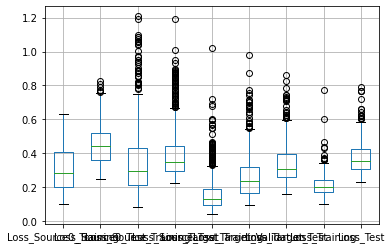

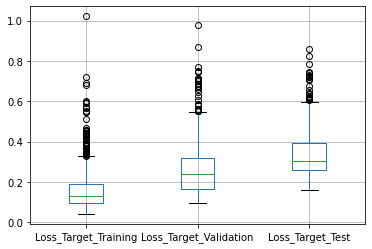

In [16]:
_ = plt.figure()
_ = df_summary.iloc[:,:9].boxplot()
_ = plt.figure()
_ = df_summary.iloc[:,4:7].boxplot()


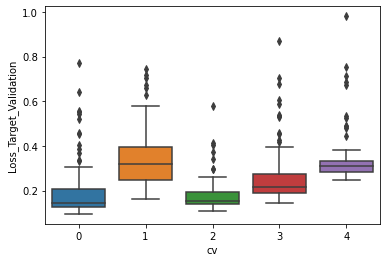

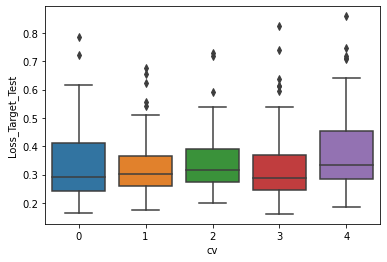

In [17]:
_ = plt.figure()
_ = sns.boxplot(data=df_summary, x='cv', y='Loss_Target_Validation')
_ = plt.figure()
_ = sns.boxplot(data=df_summary, x='cv', y='Loss_Target_Test')


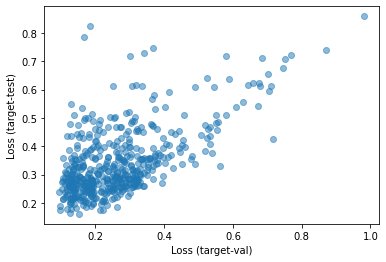

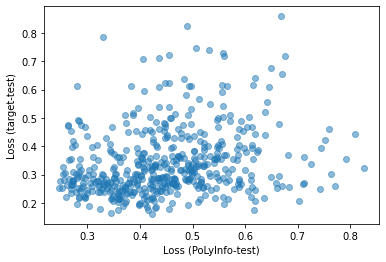

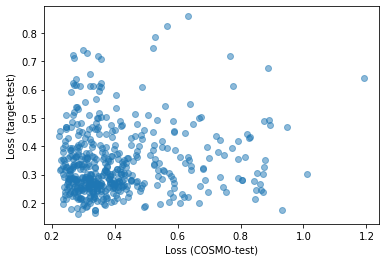

In [18]:
_ = plt.figure()
_ = plt.scatter(df_summary['Loss_Target_Validation'].values, df_summary['Loss_Target_Test'].values, alpha=0.5)
_ = plt.xlabel('Loss (target-val)')
_ = plt.ylabel('Loss (target-test)')

_ = plt.figure()
_ = plt.scatter(df_summary['Loss_Source0_Test'].values, df_summary['Loss_Target_Test'].values, alpha=0.5)
_ = plt.xlabel('Loss (PoLyInfo-test)')
_ = plt.ylabel('Loss (target-test)')

_ = plt.figure()
_ = plt.scatter(df_summary['Loss_Source_Test'].values, df_summary['Loss_Target_Test'].values, alpha=0.5)
_ = plt.xlabel('Loss (COSMO-test)')
_ = plt.ylabel('Loss (target-test)')


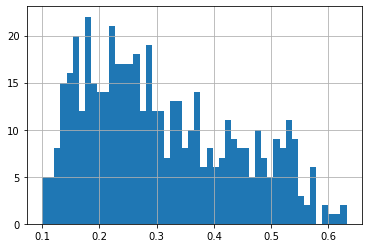

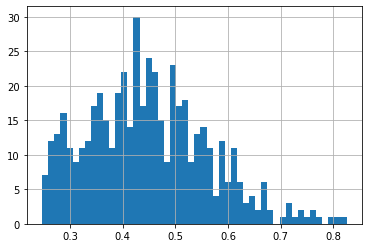

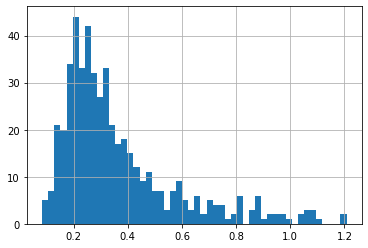

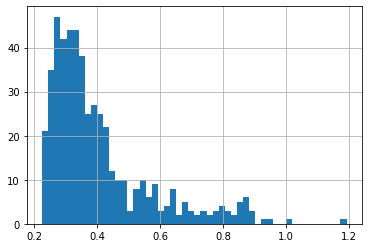

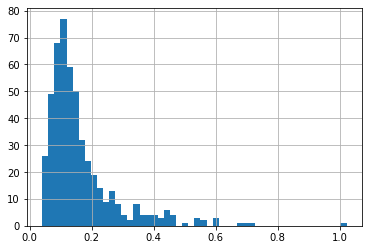

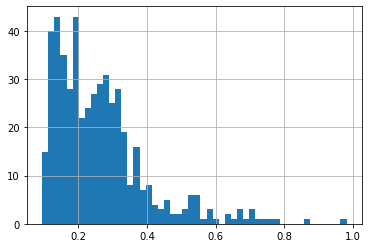

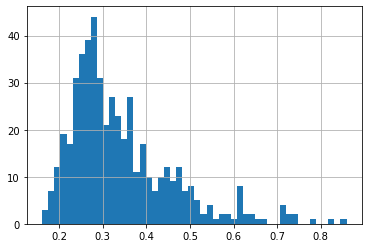

In [19]:
_ = plt.figure()
_ = df_summary['Loss_Source0_Training'].hist(bins=50)
_ = plt.figure()
_ = df_summary['Loss_Source0_Test'].hist(bins=50)
_ = plt.figure()
_ = df_summary['Loss_Source_Training'].hist(bins=50)
_ = plt.figure()
_ = df_summary['Loss_Source_Test'].hist(bins=50)
_ = plt.figure()
_ = df_summary['Loss_Target_Training'].hist(bins=50)
_ = plt.figure()
_ = df_summary['Loss_Target_Validation'].hist(bins=50)
_ = plt.figure()
_ = df_summary['Loss_Target_Test'].hist(bins=50)


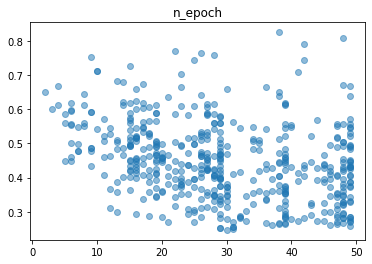

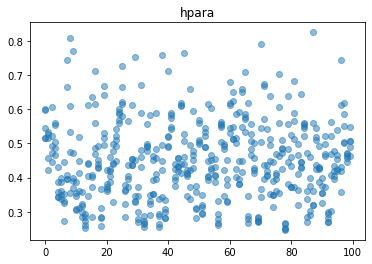

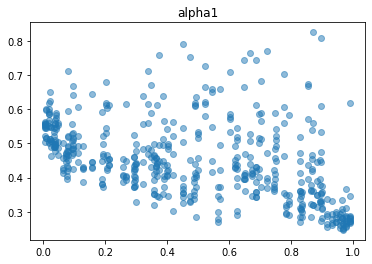

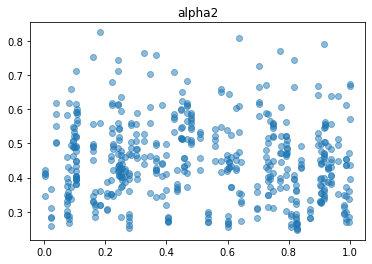

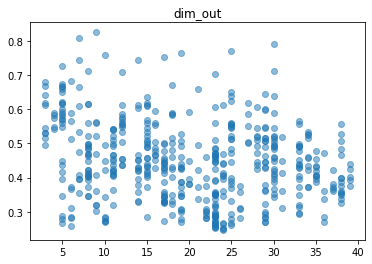

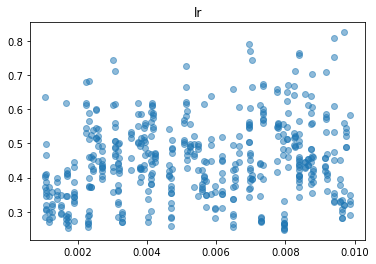

In [20]:
tar_prop = 'Loss_Source0_Test'
for col, vec_col in df_summary.iloc[:,-6:].iteritems():
    _ = plt.figure()
    _ = plt.scatter(vec_col.values, df_summary[tar_prop].values, alpha=0.5)
    _ = plt.title(col)
    

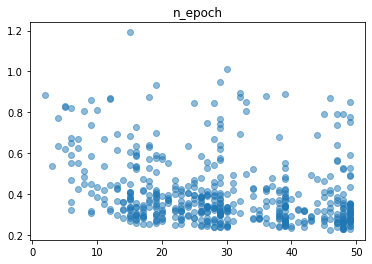

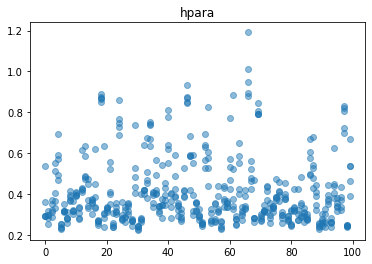

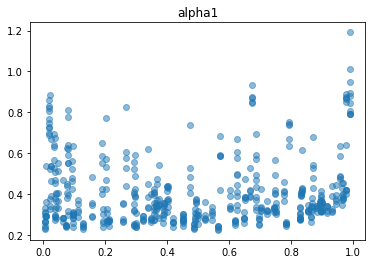

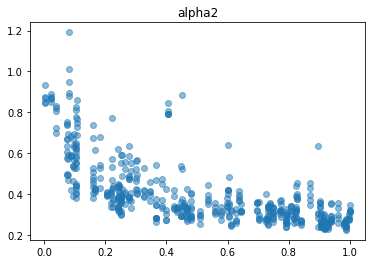

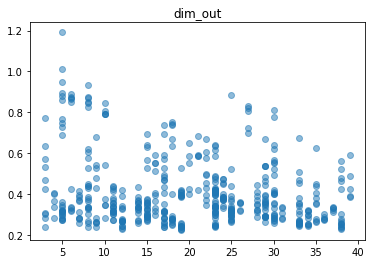

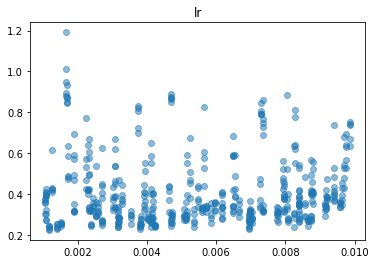

In [21]:
tar_prop = 'Loss_Source_Test'
for col, vec_col in df_summary.iloc[:,-6:].iteritems():
    _ = plt.figure()
    _ = plt.scatter(vec_col.values, df_summary[tar_prop].values, alpha=0.5)
    _ = plt.title(col)
    

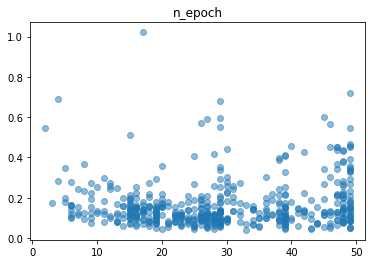

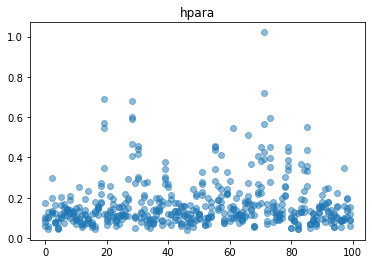

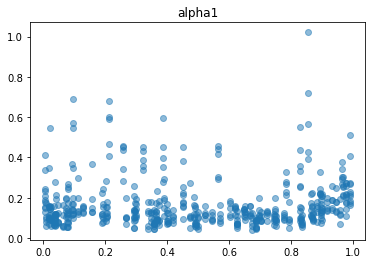

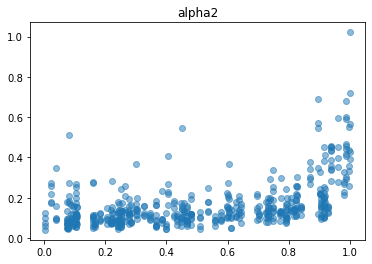

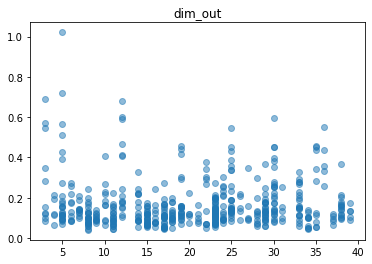

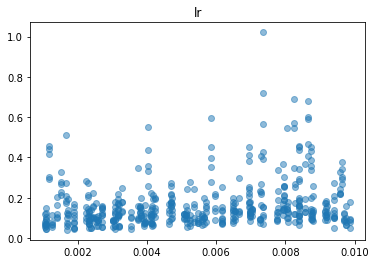

In [22]:
tar_prop = 'Loss_Target_Training'
for col, vec_col in df_summary.iloc[:,-6:].iteritems():
    _ = plt.figure()
    _ = plt.scatter(vec_col.values, df_summary[tar_prop].values, alpha=0.5)
    _ = plt.title(col)
    

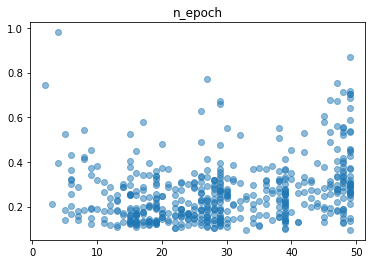

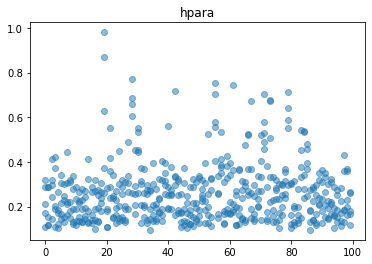

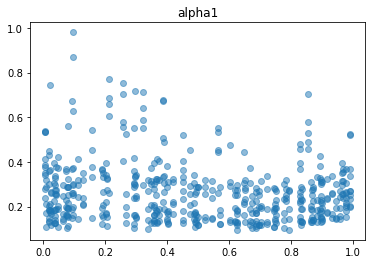

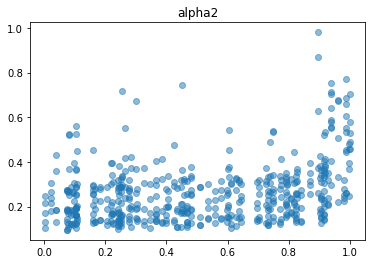

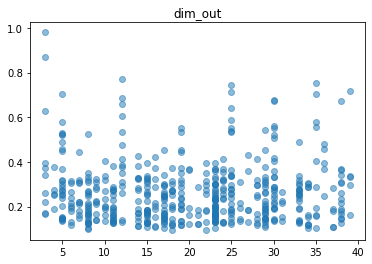

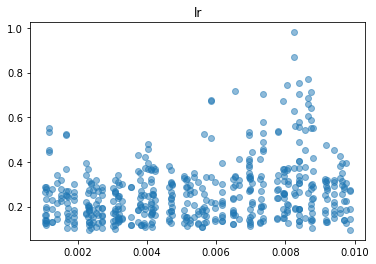

In [23]:
tar_prop = 'Loss_Target_Validation'
for col, vec_col in df_summary.iloc[:,-6:].iteritems():
    _ = plt.figure()
    _ = plt.scatter(vec_col.values, df_summary[tar_prop].values, alpha=0.5)
    _ = plt.title(col)
    

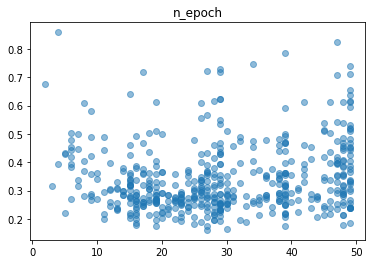

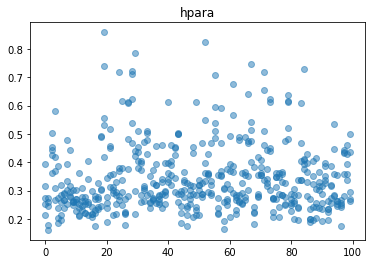

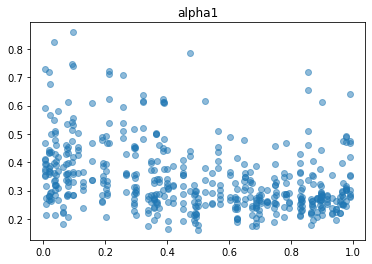

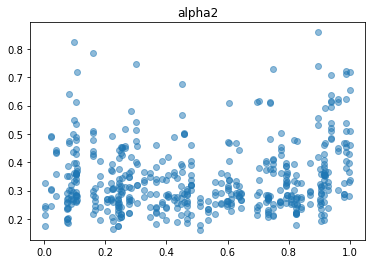

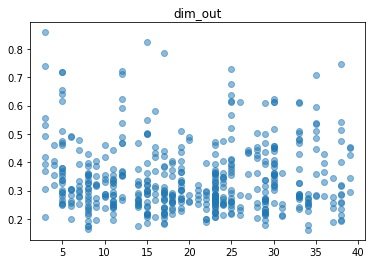

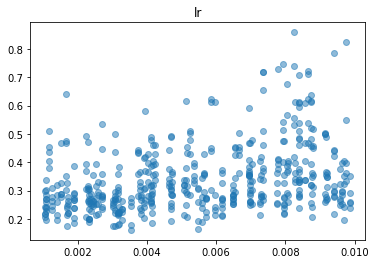

In [24]:
tar_prop = 'Loss_Target_Test'
for col, vec_col in df_summary.iloc[:,-6:].iteritems():
    _ = plt.figure()
    _ = plt.scatter(vec_col.values, df_summary[tar_prop].values, alpha=0.5)
    _ = plt.title(col)
    

### Final model training

In [25]:
dir_base2 = 'final_models/' + dir_base.split('/')[1]
os.makedirs(dir_base2, exist_ok=True)

poly_group = data_Chi.loc[idx_split_t['idx_tr'],'ps_pair']

gp_split = GroupShuffleSplit(n_splits=n_final_model, test_size=test_ratio_final, random_state=0)
idx_trs_fin, idx_vals_fin = [], []

for idx_tr, idx_val in gp_split.split(y_t['y'].loc[idx_split_t['idx_tr']], groups=poly_group.to_list()):
    idx_trs_fin.append(y_t['y'].loc[idx_split_t['idx_tr']].iloc[idx_tr].index.values)
    idx_vals_fin.append(y_t['y'].loc[idx_split_t['idx_tr']].iloc[idx_val].index.values)


In [26]:
tmp_best_para = df_summary.groupby('hpara').median().sort_values('Loss_Target_Validation').iloc[0,:][['alpha1', 'alpha2', 'dim_out', 'lr']]
alpha1 = tmp_best_para['alpha1']
alpha2 = tmp_best_para['alpha2']
dim_out = int(tmp_best_para['dim_out'])
learning_rate = tmp_best_para['lr']

alpha1, alpha2, dim_out, learning_rate


(0.4990578108519879, 0.5095921352723952, 34, 0.0035381072167457)

In [27]:
%%time

np.random.seed(0)

for iCV, (idx_tr, idx_val) in enumerate(zip(idx_trs_fin, idx_vals_fin)):
    XT_P_TR = torch.tensor(desc_t_s.loc[idx_tr, dname_p].values.astype("float"), dtype=torch.float32, device=cuda_opt)
    XT_S_TR = torch.tensor(desc_t_s.loc[idx_tr, dname_s].values.astype("float"), dtype=torch.float32, device=cuda_opt)
    XT_T_TR = torch.tensor(temp_t_s.loc[idx_tr, :].values.astype("float"), dtype=torch.float32, device=cuda_opt)
    YT_TR = torch.tensor(y_t_s.loc[idx_tr, :].values.astype("float"), dtype=torch.float32, device=cuda_opt)

    XT_P_VA = torch.tensor(desc_t_s.loc[idx_val, dname_p].values.astype("float"), dtype=torch.float32, device=cuda_opt)
    XT_S_VA = torch.tensor(desc_t_s.loc[idx_val, dname_s].values.astype("float"), dtype=torch.float32, device=cuda_opt)
    XT_T_VA = torch.tensor(temp_t_s.loc[idx_val, :].values.astype("float"), dtype=torch.float32, device=cuda_opt)
    YT_VA = torch.tensor(y_t_s.loc[idx_val, :].values.astype("float"), dtype=torch.float32, device=cuda_opt)

    generator_p = ParameterGenerator(
        in_features=dim_in_p,
        out_features=dim_out*2,
        h_neurons=dict(
            data=lambda x: neuron_vector(x, dim_in_p, dim_out*2), 
            repeat=[n_NNlayer]
        ),
        h_activation_funcs=(nn.Sigmoid(), ),
        h_dropouts=(0.0,)
    )

    generator_s = ParameterGenerator(
        in_features=dim_in_s,
        out_features=dim_out*2,
        h_neurons=dict(
            data=lambda x: neuron_vector(x, dim_in_s, dim_out*2), 
            repeat=[n_NNlayer]
        ),
        h_activation_funcs=(nn.Sigmoid(), ),
        h_dropouts=(0.0,)
    )

    for iM, ((paras_p, model_p), (paras_s, model_s)) in enumerate(zip(generator_p(num=1, factory=SequentialLinear), generator_s(num=1, factory=SequentialLinear))):
        dir_save = f'{dir_base2}/model_{iCV}'
        os.makedirs(dir_save, exist_ok=True)

        c_model = Chi_Model(model_p, model_s, dim_out)
        c_model.to(cuda_opt)

        c_model.train()

        optimizer = optim.Adam(c_model.parameters(), lr=learning_rate, amsgrad=True)
        scheduler = StepLR(optimizer, step_size=sch_step_size, gamma=sch_gamma)

        learning_curve = pd.DataFrame()

        for t in range(epochs_s):
            # mini-batch of training data
            kf = KFold(n_splits=n_minibatch_PI, shuffle=True)
            idx_mb_s0 = [x for _, x in kf.split(XS0_P_TR)]

            # pre-training with PI
            for tt, ii_s0 in enumerate(idx_mb_s0):
                c_model.train()

                tmp_source0_train = c_model(XS0_P_TR[ii_s0,:], XS0_S_TR[ii_s0,:], XS0_T_TR[ii_s0,:])
                py_source0_train = tmp_source0_train[:,0:1]
                loss_source0_train = criterion_source0(py_source0_train, YS0_TR[ii_s0,:])

                optimizer.zero_grad()
                loss_source0_train.backward()
                optimizer.step()

                c_model.eval()
                with torch.no_grad():
                    py_source_train = c_model(XS_P_TR, XS_S_TR, XS_T_TR)[:,1:2]
                    py_target_train = c_model(XT_P_TR, XT_S_TR, XT_T_TR)[:,2:3]
                    loss_source_train = criterion_source(py_source_train, YS_TR)
                    loss_target_train = criterion_target(py_target_train, YT_TR)*loss_factor_target
                    loss_train = alpha1*loss_source0_train + (1.0-alpha1)*(alpha2*loss_source_train + (1.0-alpha2)*loss_target_train)

                    py_target_val = c_model(XT_P_VA, XT_S_VA, XT_T_VA)[:,1:2]
                    loss_target_val = criterion_target(py_target_val, YT_VA)*loss_factor_target

                    py_source0_test = c_model(XS0_P_TE, XS0_S_TE, XS0_T_TE)[:,0:1]
                    py_source_test = c_model(XS_P_TE, XS_S_TE, XS_T_TE)[:,1:2]
                    py_target_test = c_model(XT_P_TE, XT_S_TE, XT_T_TE)[:,2:3]
                    loss_source0_test = criterion_source0(py_source0_test, YS0_TE)
                    loss_source_test = criterion_source(py_source_test, YS_TE)
                    loss_target_test = criterion_target(py_target_test, YT_TE)*loss_factor_target
                    loss_test = alpha1*loss_source0_test + (1.0-alpha1)*(alpha2*loss_source_test + (1.0-alpha2)*loss_target_test)

                learning_curve = pd.concat([learning_curve, pd.Series({
                                        "Loss_Source0_Training": loss_source0_train.item(), 
                                        "Loss_Source0_Test": loss_source0_test.item(),
                                        "Loss_Source_Training": loss_source_train.item(), 
                                        "Loss_Source_Test": loss_source_test.item(),
                                        "Loss_Target_Training": loss_target_train.item(),
                                        "Loss_Target_Validation":loss_target_val.item(),
                                        "Loss_Target_Test":loss_target_test.item(),
                                        "Loss_Training":loss_train.item(),
                                        "Loss_Test":loss_test.item()},
                                       name=f'pre_{t}').to_frame().T], axis=0)

        # main training
        best_loss_val = np.inf
        for t in range(epochs):
            # mini-batch of training data
            kf = KFold(n_splits=n_minibatch_PI, shuffle=True)
            idx_mb_s0 = [x for _, x in kf.split(XS0_P_TR)]
            idx_mb_s, idx_mb_t = [], []
            for k in range(n_factor_COSMO):
                kf = KFold(n_splits=n_minibatch_COSMO, shuffle=True)
                idx_mb_s += [x for _, x in kf.split(XS_P_TR)]
            for k in range(n_factor_CHI):
                kf = KFold(n_splits=n_minibatch_CHI, shuffle=True)
                idx_mb_t += [x for _, x in kf.split(XT_P_TR)]

            for tt, (ii_s0, ii_s, ii_t) in enumerate(zip(idx_mb_s0, idx_mb_s, idx_mb_t)):
                c_model.train()
                if alpha1 > 0:
                    py_source0_train = c_model(XS0_P_TR[ii_s0,:], XS0_S_TR[ii_s0,:], XS0_T_TR[ii_s0,:])[:,0:1]
                    loss_source0_train = criterion_source0(py_source0_train, YS0_TR[ii_s0,:])
                else:
                    loss_source0_train = torch.zeros(1, device=cuda_opt)

                if (alpha2 > 0) and (alpha1 < 1):
                    if no_COSMO_BN:
                        c_model.eval()
                    else:
                        c_model.train()
                    py_source_train = c_model(XS_P_TR[ii_s,:], XS_S_TR[ii_s,:], XS_T_TR[ii_s,:])[:,1:2]
                    loss_source_train = criterion_source(py_source_train, YS_TR[ii_s,:])
                else:
                    loss_source_train = torch.zeros(1, device=cuda_opt)

                if (alpha1 < 1) and (alpha2 < 1):
                    if no_target_BN:
                        c_model.eval()
                    else:
                        c_model.train()
                    py_target_train = c_model(XT_P_TR[ii_t,:], XT_S_TR[ii_t,:], XT_T_TR[ii_t,:])[:,2:3]
                    loss_target_train = criterion_target(py_target_train, YT_TR[ii_t,:])*loss_factor_target
                else:
                    loss_target_train = torch.zeros(1, device=cuda_opt)

                loss_train = alpha1*loss_source0_train + (1.0-alpha1)*(alpha2*loss_source_train + (1.0-alpha2)*loss_target_train)

                optimizer.zero_grad()
                loss_train.backward()
                optimizer.step()

                c_model.eval()
                with torch.no_grad():
                    py_target_val = c_model(XT_P_VA, XT_S_VA, XT_T_VA)[:,2:3]
                    loss_target_val = criterion_target(py_target_val, YT_VA)*loss_factor_target

                    py_source0_test = c_model(XS0_P_TE, XS0_S_TE, XS0_T_TE)[:,0:1]
                    py_source_test = c_model(XS_P_TE, XS_S_TE, XS_T_TE)[:,1:2]
                    py_target_test = c_model(XT_P_TE, XT_S_TE, XT_T_TE)
                    loss_source0_test = criterion_source0(py_source0_test, YS0_TE)
                    loss_source_test = criterion_source(py_source_test, YS_TE)
                    loss_target_test = criterion_target(py_target_test[:,2:3], YT_TE)*loss_factor_target
                    loss_test = alpha1*loss_source0_test + (1.0-alpha1)*(alpha2*loss_source_test + (1.0-alpha2)*loss_target_test)

                learning_curve = pd.concat([learning_curve, pd.Series({
                                        "Loss_Source0_Training": loss_source0_train.item(), 
                                        "Loss_Source0_Test": loss_source0_test.item(),
                                        "Loss_Source_Training": loss_source_train.item(), 
                                        "Loss_Source_Test": loss_source_test.item(),
                                        "Loss_Target_Training": loss_target_train.item(),
                                        "Loss_Target_Validation":loss_target_val.item(),
                                        "Loss_Target_Test":loss_target_test.item(),
                                        "Loss_Training":loss_train.item(),
                                        "Loss_Test":loss_test.item()},
                                       name=f'main_{t}_{tt}').to_frame().T], axis=0)

                if (t > burn_in) and (loss_target_val < best_loss_val):
                    save_NN(paras_p, paras_s, dim_out, c_model, f'{dir_save}/best_loss_target_val.pt')

                    with torch.no_grad():
                        py_source0_train = c_model(XS0_P_TR, XS0_S_TR, XS0_T_TR)[:,0:1]
                        py_source_train = c_model(XS_P_TR, XS_S_TR, XS_T_TR)[:,1:2]
                        py_target_train = c_model(XT_P_TR, XT_S_TR, XT_T_TR)[:,2:3]
                    pd.concat([y_s0.loc[idx_split_s0['idx_tr'],:], pd.Series(py_source0_train.to('cpu').detach().numpy().flatten(), index=idx_split_s0['idx_tr'], name='pred')] , axis=1
                             ).to_csv(f'{dir_save}/best_loss_target_val_source0_train.csv')
                    pd.concat([y_s.loc[idx_split_s['idx_tr'],:], pd.Series(ys_scaler.inverse_transform(py_source_train.to('cpu').detach().numpy()).flatten(), index=idx_split_s['idx_tr'], name='pred')] , axis=1
                             ).to_csv(f'{dir_save}/best_loss_target_val_source_train.csv')
                    pd.concat([y_t.loc[idx_tr,:], pd.Series(yt_scaler.inverse_transform(py_target_train.to('cpu').detach().numpy()).flatten(), index=idx_tr, name='pred')] , axis=1
                             ).to_csv(f'{dir_save}/best_loss_target_val_target_train.csv')

                    pd.concat([y_t.loc[idx_val,:], pd.Series(yt_scaler.inverse_transform(py_target_val.to('cpu').detach().numpy()).flatten(), index=idx_val, name='pred')] , axis=1
                             ).to_csv(f'{dir_save}/best_loss_target_val_target_val.csv')

                    pd.concat([y_s0.loc[idx_split_s0['idx_te'],:], pd.Series(py_source0_test.to('cpu').detach().numpy().flatten(), index=idx_split_s0['idx_te'], name='pred')] , axis=1
                             ).to_csv(f'{dir_save}/best_loss_target_val_source0_test.csv')
                    pd.concat([y_s.loc[idx_split_s['idx_te'],:], pd.Series(ys_scaler.inverse_transform(py_source_test.to('cpu').detach().numpy()).flatten(), index=idx_split_s['idx_te'], name='pred')] , axis=1
                             ).to_csv(f'{dir_save}/best_loss_target_val_source_test.csv')
                    pd.concat([y_t.loc[idx_split_t['idx_te'],:], pd.Series(yt_scaler.inverse_transform(py_target_test[:,2:3].to('cpu').detach().numpy()).flatten(), index=idx_split_t['idx_te'], name='pred')] , axis=1
                             ).to_csv(f'{dir_save}/best_loss_target_val_target_test.csv')
                    
                    tmp_mat = py_target_test.to('cpu').detach().numpy()
                    tmp_mat[:,1:2] = ys_scaler.inverse_transform(tmp_mat[:,1:2])
                    tmp_mat[:,2:3] = yt_scaler.inverse_transform(tmp_mat[:,2:3])
                    tmp_mat = pd.DataFrame(tmp_mat)
                    tmp_mat.columns = ['Soluble', 'Chi_COSMO', 'Chi_Exp', 'Z_sol', 'A_COSMO', 'B_COSMO', 'A_Exp', 'B_Exp'] + [f'Z_{x}' for x in range(dim_out)]
                    tmp_mat.to_csv(f'{dir_save}/output_target_test.csv')

                    best_loss_val = loss_target_val

            scheduler.step()

        learning_curve.to_csv(f'{dir_save}/learning_curve.csv')

    print(f'Finished model {iCV}')


Finished model 0
Finished model 1
Finished model 2
Finished model 3
Finished model 4
Finished model 5
Finished model 6
Finished model 7
Finished model 8
Finished model 9
CPU times: user 5min 20s, sys: 1min 34s, total: 6min 55s
Wall time: 4min 47s
